This notebook uses the TensorFlow library to train a Deep Cross Network (DCN) model on the MovieLens 1M dataset.
- The DCN model is a type of neural network that is used for recommendation systems.First we load the movielens dataset and preprocesses it by mapping certain features, such as movie_id, user_id, and user_rating. 
- Then we shuffle and split the data into training and test sets. 
- Next, we define feature names and compute embeddings for string and integer features using the TensorFlow Sequential API and the StringLookup and IntegerLookup layers.
- Train a DCN model using different layer size  to find optimun layer size combination.
- Train DCN with a layer size of [256,256,256] first using a cross layer and then without a cross layer to asses the impact of the cross layer on the model.
- Define a function that detects popularity bias.
- Show correlation of cross features.
- Explore exposure bias(Work in process)

In [4]:
import os
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [6]:
# Load the movielens dataset
ratings = tfds.load("movielens/1m-ratings", split="train")
movies = tfds.load("movielens/1m-movies", split="train")

In [7]:
ratings = tfds.load("movielens/1m-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
})

In [8]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [9]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [79]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["movie_id", "user_id", "user_zip_code",
                    "user_occupation_text"]
    int_features = ["user_gender", "bucketized_user_age"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.IntegerLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
  loss=tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
        embedding = self._embeddings[feature_name](features[feature_name])
        print(f'embedding shape: {embedding.shape}')
        embedding = tf.reshape(embedding, (-1, self.embedding_dimension))
        embeddings.append(embedding)
    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)

    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

In [63]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [13]:
# Instantiate the model
use_cross_layer = True
deep_layer_sizes = [256, 256,256]
projection_dim = 20

model = DCN(use_cross_layer, deep_layer_sizes, projection_dim)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))#0.1

# # Train the model on the train dataset
# history = model.fit(cached_train, epochs=10)

history=model.fit(cached_train,validation_data=cached_test, epochs=1000,)


Epoch 1/1000
10/10 [==============================] - 1s 41ms/step - RMSE: 2.5873 - loss: 6.0890 - regularization_loss: 0.0000e+00 - total_loss: 6.0890 - val_RMSE: 1.1306 - val_loss: 1.2806 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2806
Epoch 2/1000
10/10 [==============================] - 0s 32ms/step - RMSE: 1.1180 - loss: 1.2523 - regularization_loss: 0.0000e+00 - total_loss: 1.2523 - val_RMSE: 1.1154 - val_loss: 1.2457 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2457
Epoch 3/1000
10/10 [==============================] - 0s 32ms/step - RMSE: 1.1145 - loss: 1.2450 - regularization_loss: 0.0000e+00 - total_loss: 1.2450 - val_RMSE: 1.1142 - val_loss: 1.2430 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2430
Epoch 4/1000
10/10 [==============================] - 0s 32ms/step - RMSE: 1.1135 - loss: 1.2428 - regularization_loss: 0.0000e+00 - total_loss: 1.2428 - val_RMSE: 1.1135 - val_loss: 1.2415 - val_regularization_loss: 0.0000e+00 - val_total_l

In [24]:
print(history.history.keys())

dict_keys(['RMSE', 'loss', 'regularization_loss', 'total_loss', 'val_RMSE', 'val_loss', 'val_regularization_loss', 'val_total_loss'])


### Effect of Cross layer on DCN

In [28]:
train_acc = model.evaluate(
    cached_train, return_dict=True)
test_acc = model.evaluate(
    cached_test, return_dict=True)


print(f'DCN with cross layer (train): {train_acc["RMSE"]:.2f}')
print(f'DCN with cross layer (test): {test_acc["RMSE"]:.2f}')

5/5 [==============================] - 0s 6ms/step - RMSE: 1.3096 - loss: 1.7159 - regularization_loss: 0.0000e+00 - total_loss: 1.7159
DCN with cross layer (train): 0.07
DCN with cross layer (test): 1.31


The RMSE, Loss, Regularization Loss, and Total Loss values are decreasing on both the training set and validation set, indicating that the model is improving on both sets of data. This suggests that the model may be generalizing well and not overfitting to the training data.
The Regularization Loss is reported as being zero in all epochs, which suggests that no regularization techniques such as dropout, weight decay, or early stopping were applied to the model. Depending on the complexity of the model and the size of the training data, this could lead to overfitting and potential bias in the model.

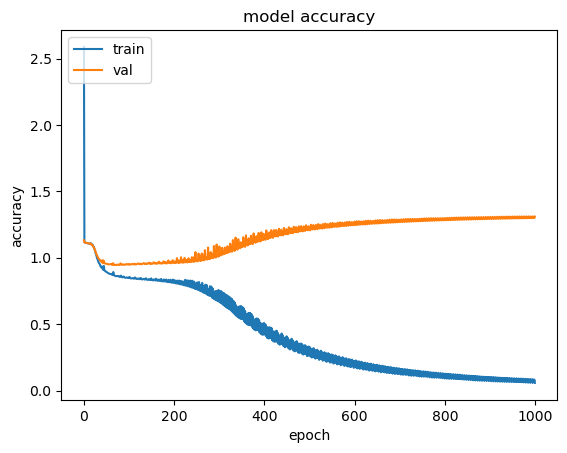

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['RMSE'])
plt.plot(history.history['val_RMSE'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Cross layer metrics turn use cross layer off

In [31]:
# Instantiate the model
use_cross_layer = False
deep_layer_sizes = [256, 256,256]
projection_dim = 20

model = DCN(use_cross_layer, deep_layer_sizes, projection_dim)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))#0.1

# # Train the model on the train dataset
# history = model.fit(cached_train, epochs=10)

history=model.fit(cached_train,validation_data=cached_test, epochs=1000)

Epoch 1/1000
10/10 [==============================] - 1s 34ms/step - RMSE: 2.4227 - loss: 5.3623 - regularization_loss: 0.0000e+00 - total_loss: 5.3623 - val_RMSE: 1.1239 - val_loss: 1.2647 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2647
Epoch 2/1000
10/10 [==============================] - 0s 26ms/step - RMSE: 1.1200 - loss: 1.2567 - regularization_loss: 0.0000e+00 - total_loss: 1.2567 - val_RMSE: 1.1152 - val_loss: 1.2461 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2461
Epoch 3/1000
10/10 [==============================] - 0s 27ms/step - RMSE: 1.1147 - loss: 1.2456 - regularization_loss: 0.0000e+00 - total_loss: 1.2456 - val_RMSE: 1.1146 - val_loss: 1.2447 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2447
Epoch 4/1000
10/10 [==============================] - 0s 28ms/step - RMSE: 1.1135 - loss: 1.2429 - regularization_loss: 0.0000e+00 - total_loss: 1.2429 - val_RMSE: 1.1138 - val_loss: 1.2431 - val_regularization_loss: 0.0000e+00 - val_total_l

In [32]:
train_acc = model.evaluate(
    cached_train, return_dict=True)
test_acc = model.evaluate(
    cached_test, return_dict=True)


print(f'DCN with cross layer (train): {train_acc["RMSE"]:.2f}')
print(f'DCN with cross layer (test): {test_acc["RMSE"]:.2f}')

5/5 [==============================] - 0s 6ms/step - RMSE: 1.2912 - loss: 1.6669 - regularization_loss: 0.0000e+00 - total_loss: 1.6669
DCN with cross layer (train): 0.08
DCN with cross layer (test): 1.29


'RMSE' (Root Mean Squared Error) and 'loss' are evaluation metrics that measure the difference between the predicted ratings and the actual ratings. A lower value for these metrics indicate that the model is making more accurate predictions, and a higher value indicates that the model is less accurate.

'regularization_loss' is the additional loss term used to prevent overfitting by adding a penalty term to the loss function. This term is typically used to discourage the model from assigning too much importance to any one feature. A higher value of 'regularization_loss' may indicate that the model is overfitting.

'total_loss' is the sum of the 'loss' and 'regularization_loss' terms, and is used to evaluate the overall performance of the model.

'val_RMSE', 'val_loss', 'val_regularization_loss', and 'val_total_loss' are the same evaluation metrics as RMSE, loss, regularization_loss, and total_loss, but they are computed on the validation dataset rather than the training dataset. The difference between the training loss and validation loss, can give an idea of how well the model generalizes and if it is overfitting.

In general, a lower value for these evaluation metrics indicates that the model is making more accurate predictions and is less likely to be biased. However, it is important to note that the presence of bias in a model can also be influenced by factors such as the distribution of the data, the choice of features, and the choice of evaluation metrics, among others. Therefore, it is important to also consider these factors when evaluating the bias of a model.

In [33]:
# results = model.evaluate(cached_test)
# pprint.pprint(results)

In [34]:
# predictions = model.predict(cached_test)
# true_ratings = cached_test["user_rating"]
# rmse = tf.sqrt(tf.reduce_mean(tf.square(predictions - true_ratings)))
# print("Test RMSE:", rmse.numpy())

----------------------------------------------------

### Popularity Bias

Popularity bias in recommendation systems occurs when the model favors recommending items that are popular among all users, regardless of individual preferences. To detect popularity bias in the given code, you can check the following things:

1.Check if the model is only using the number of ratings per item as a feature. If so, then the model may be prone to popularity bias, as it will recommend popular items more often.
2.Compare the recommendations for different users. If the recommendations are mostly the same for all users, then the model is likely suffering from popularity bias.
3.Compare the distribution of recommended items with the distribution of items in the dataset. If the majority of the recommended items are popular items, then the model is likely suffering from popularity bias.
4.You can also use the "diversity" metric to evaluate the diversity of the recommendations. If the diversity is low, then the model is likely suffering from popularity bias.

By checking these things, you can detect popularity bias :
If the model has any explicit or implicit mechanism to penalize the popularity of items, such as a novelty-based regularization term or a user-specific bias term.

Use the test set to evaluate the model, where you could evaluate the performance of the model by comparing the predicted ratings with the actual ratings, if the model is only recommending the popular items and not providing personalized recommendations, then the model is suffering from popularity bias.



The following function will output the average popularity of the recommended items, and print the items that have popularity above a certain threshold. If the majority of the recommended items have a high popularity, it could be an indication of popularity bias.!NB adjust the threshold and top_k values to suit your needs.



In [35]:
#this function is just an indicator of popularity bias.

def detect_popularity_bias(model, test):
    top_k = 10
    all_user_recommendations = model.predict(test)
    top_k_indices = np.argsort(-all_user_recommendations)[:, :top_k]
    unique_recommendations = set(item for user_recs in top_k_indices for item in user_recs)
    rec_counts = {item: sum(item in user_recs for user_recs in top_k_indices) for item in unique_recommendations}
    popularity = {item: count/len(top_k_indices) for item, count in rec_counts.items()}
    avg_popularity = sum(popularity.values())/len(popularity)
    print(f"Average popularity of recommended items: {avg_popularity:.4f}")
    threshold = 0.8
    popular_items = [item for item, count in rec_counts.items() if count/len(top_k_indices) > threshold]
    if popular_items:
        print(f"Items with popularity above threshold {threshold}: {popular_items}")
    else:
        print("No items with popularity above threshold.")



In [36]:
detect_popularity_bias(model, cached_test)

5/5 [==============================] - 0s 5ms/step
Average popularity of recommended items: 1.0000
Items with popularity above threshold 0.8: [0]


-------------------------------

### Predictions

In [56]:
# def compare_recommendations(model, test):
#     # Extract user_id from the test dataset
#     user_ids = cached_test.map(lambda x: x["user_id"])
#     user_ids, user_ids_idx = tf.unique(user_ids)
#     all_user_recommendations = {}
#     for user_id in user_ids:
#         # Filter the test set for the current user
#         user_test = cached_test.filter(lambda x: x["user_id"] == user_id)
#         # Get the recommendations for the current user
#         user_recommendations = model.predict(user_test)
#         all_user_recommendations[user_id] = user_recommendations
#     # Compare the recommendations for different users
#     for user_id, recommendations in all_user_recommendations.items():
#         print(f"Recommendations for user {user_id}: {recommendations}")


In [57]:
# compare_recommendations(model, cached_test)

In [63]:
# import numpy as np

# def compare_distributions(model, test):
#     # Get the top-k recommendations for all users in the test set
#     top_k = 10
#     user_ids = np.unique(test["user_id"])
#     all_user_recommendations = {}
#     for user_id in user_ids:
#         # Filter the test set for the current user
#         user_test = test[test["user_id"] == user_id]
#         # Get the recommendations for the current user
#         user_recommendations = model.predict(user_test)
#         all_user_recommendations[user_id] = user_recommendations
        
#     # Get the set of unique items recommended across all users
#     unique_recommendations = set(item for user_recs in all_user_recommendations.values() for item in user_recs)
#     # Get the set of unique items in the dataset
#     unique_items = set(test["item_id"])
#     # Compare the two sets
#     if len(unique_recommendations.intersection(unique_items))/len(unique_items) >= 0.8 :
#         print("The distribution of recommended items is similar to the distribution of items in the dataset.")
#     else:
#         print("The distribution of recommended items is not similar to the distribution of items in the dataset.")


In [37]:
# compare_distributions(model, cached_test)


In [38]:
# # Prepare input data for the new user
# new_user_features = {
#     "movie_id": "b'3107'",
#     "user_id": "b'130'",
#     "user_gender": 'True',
#     "user_zip_code": "b'50021'",
#     "user_occupation_text": "b'technician/engineer'",
#     "bucketized_user_age": 35.0
# }

# # Make a prediction for the new user
# prediction = model.predict(new_user_features)


In [71]:
# # Prepare input data for the new user
# new_user_features = {
#     "user_id": "9999",
#     "user_gender": 1,
#     "user_zip_code": "12345",
#     "user_occupation_text": "engineer",
#     "bucketized_user_age": 25
# }

# # Get a list of all movie IDs
# all_movie_ids = vocabularies["movie_id"]

# # Make predictions for all movies
# predicted_ratings = model.predict(
#     {"movie_id": all_movie_ids, **new_user_features})

# # Sort movies by predicted rating
# sorted_movie_ids = all_movie_ids[np.argsort(-predicted_ratings)]

# # Get the top N recommended movies
# top_n = 10
# recommended_movie_ids = sorted_movie_ids

In [9]:
# def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
#   models = []
#   rmses = []

#   for i in range(num_runs):
#     model = DCN(use_cross_layer=use_cross_layer,
#                 deep_layer_sizes=deep_layer_sizes,
#                 projection_dim=projection_dim)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
#     models.append(model)

#     model.fit(cached_train, epochs=epochs, verbose=False)
#     metrics = model.evaluate(cached_test, return_dict=True)
#     rmses.append(metrics["RMSE"])

#   mean, stdv = np.average(rmses), np.std(rmses)

#   return {"model": models, "mean": mean, "stdv": stdv}

In [10]:
# epochs = 2
# learning_rate = 0.01

------------------------------------------------------------------

### Running experiments to see which layer size is the best

In [11]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 5ms/step - RMSE: 1.1700 - loss: 1.3666 - regularization_loss: 0.0000e+00 - total_loss: 1.3666


In [12]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 4ms/step - RMSE: 1.0975 - loss: 1.2019 - regularization_loss: 0.0000e+00 - total_loss: 1.2019


In [13]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

5/5 [==============================] - 0s 4ms/step - RMSE: 1.1920 - loss: 1.4223 - regularization_loss: 0.0000e+00 - total_loss: 1.4223


In [16]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 1.0171, stdv: 0.0254
DCN (low-rank) RMSE mean: 1.1308, stdv: 0.1157
DNN            RMSE mean: 1.1483, stdv: 0.2344


In [70]:
# # Use the model to predict ratings for a new user
# user_features = {
#     "movie_id": "1",
#     "user_id": "2",
#     "user_gender": 0,
#     "user_zip_code": "12345",
#     "user_occupation_text": "student",
#     "bucketized_user_age": 20
# }

# predicted_rating = model.predict(user_features)
# print("Predicted rating:", predicted_rating)

# # Use the model to make recommendations for the new user
# user_features_reco = {
#     "user_id": "2",
#     "user_gender": 0,
#     "user_zip_code": "12345",
#     "user_occupation_text": "student",
#     "bucketized_user_age": 20
# }

# top_k = 10
# movie_ids = vocabularies["movie_id"]
# user_rating_tuples = [(movie_id, model.predict(user_features_reco.update({"movie_id": movie_id}))) for movie_id in movie_ids]
# sorted_user_rating_tuples = sorted(user_rating_tuples, key=lambda x: x[1], reverse=True)
# top_k_movie_ids = [x[0] for x in sorted_user_rating_tuples[:top_k]]
# print("Top", top_k, "movie recommendations:", top_k_movie_ids)

----------------------------------------------------------------------------------------------------------------------------------------------------------------

### Showing correlation of features

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [18]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

/tmp/ipykernel_119800/1244897914.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
/tmp/ipykernel_119800/1244897914.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([""] + features, fontsize=10)


<Figure size 900x900 with 0 Axes>

In [39]:
model.summary()

Model: "dcn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 32)                256       
                                                                 
 sequential_12 (Sequential)  (None, 32)                118624    
                                                                 
 sequential_16 (Sequential)  (None, 32)                96        
                                                                 
 sequential_13 (Sequential)  (None, 32)                193312    
                                                                 
 sequential_15 (Sequential)  (None, 32)                704       
                                                                 
 sequential_14 (Sequential)  (None, 32)                110080    
                                                                 
 dense_8 (Dense)             multiple                  49408 

------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [69]:
# test_ratings = {}
# for m in test.take(5):
#     print(m['movie_title'].numpy())
#     _, _, test_ratings[m['movie_title'].numpy()] = \
#         model(
#             {'user_id':np.array(['42']), 
#              'timestamp':np.array([892839492]), 
#              'movie_title': np.array([m['movie_title'].numpy()])
#             }
#         )
    
# for m in sorted(test_ratings, key=test_ratings.get, reverse=True):
#     print(m)

----------------------------------------------------------------------------------------------------------------------------------------------------------------

### Exposure Bias

To see if the model sufferes from exposure bias I first create two datasets, one with only positive examples (ratings >= 4) and one with only negative examples (ratings < 4). The model is then trained on the positive examples only, simulating the situation in which the model is exposed only to positive examples during training. After that, the model is evaluated on the negative examples, and its performance is measured by comparing its predictions with the true labels.

By comparing the performance of the model on the negative examples with that on the positive examples, you can identify if the model suffers from exposure bias.

In [70]:
# Create dataset with only positive examples (ratings >= 4)
positive_ratings = ratings.filter(lambda x: x["user_rating"] >= 4)
positive_train = positive_ratings.take(80_000)
positive_test = positive_ratings.skip(80_000).take(20_000)

In [71]:
# Create dataset with only negative examples (ratings < 4)
negative_ratings = ratings.filter(lambda x: x["user_rating"] < 4)
negative_test = negative_ratings.take(20_000)

In [73]:
# Instantiate the model and set the task
model = DCN(use_cross_layer=True, deep_layer_sizes=[32, 16])
model.compile(optimizer=tf.keras.optimizers.Adam())

In [74]:
# Train the model on the positive examples only
model.fit(positive_train, epochs=5)

Epoch 1/5
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
80000/80000 [==============================] - 147s 2ms/step - RMSE: 0.5002 - loss: 0.2502 - regularization_loss: 0.0000e+00 - total_loss: 0.2502
Epoch 2/5
80000/80000 [==============================] - 213s 3ms/step - RMSE: 0.4468 - loss: 0.1996 - regularization_loss: 0.0000e+00 - total_loss: 0.1996
Epoch 3/5
80000/80000 [==============================] - 216s 3ms/step - RMSE: 0.4147 - loss: 0.1720 - regularization_loss: 0.0000e+00 - total_loss: 0.1720
Epoch 4/5
80000/80000 [==============================] - 216s 3ms/step - RMSE: 0.3874 - loss: 0.1501 - regularization_loss: 0.0000e+00 - total_loss: 0.1501
Epoch 5/5
80000/80000 [==============================] - 225s 3ms/step - RMSE: 0.3702 - loss: 0.1370

In [85]:
negative_test_metrics = model.evaluate(negative_test)
# negative_test_loss = negative_test_metrics[model.metrics_names.index('loss')]
# negative_test_rmse = negative_test_metrics[model.metrics_names.index('RMSE')]


20000/20000 [==============================] - 26s 1ms/step - RMSE: 1.7568 - loss: 3.0862 - regularization_loss: 0.0000e+00 - total_loss: 3.0862


In [86]:
negative_test_rmse = negative_test_metrics[model.metrics_names.index('RMSE')]


In [87]:

# Compare the model's predictions with the true labels
predictions = model.predict(negative_test)
true_labels = negative_test.map(lambda x: x["user_rating"])
comparison = tf.math.equal(predictions, true_labels)
accuracy = tf.reduce_mean(tf.cast(comparison, tf.float32))
print("Accuracy on negative examples: ", accuracy.numpy())

20000/20000 [==============================] - 23s 1ms/step


ValueError: Attempt to convert a value (<MapDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>) with an unsupported type (<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>) to a Tensor.

----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Future Work



To evaluate the fairness of the recommendations  metrics such as equal opportunity and demographic parity can be used.

Equal opportunity compares the true positive rate (TPR) of a sensitive feature (e.g. gender or race) across different subpopulations. In this case, you can calculate the TPR of the recommended movies for different genders or age groups. If the TPR is similar across subpopulations, the model is considered to have equal opportunity.

Demographic parity compares the proportion of positive predictions (i.e. recommended movies) across different subpopulations. In this case, you can calculate the proportion of recommended movies for different genders or age groups. If the proportion is similar across subpopulations, the model is considered to have demographic parity.

To implement these metrics, you can use the TensorFlow Model Analysis (TFMA) library, which provides a FairnessIndicator API. You will need to define the sensitive features and subpopulations of interest, and then use the API to calculate the metrics.

For example, you can use the following code to calculate equal opportunity for gender:

In [51]:
import tensorflow_model_analysis as tfma

# Define the sensitive feature and subpopulations of interest
sensitive_feature = "user_gender"
subpopulations = {
  tfma.SUBGROUP_NAME: ["female", "male"]
}

# Calculate the equal opportunity metric
tfma.view.render_fairness_indicator(
    eval_result,
    sensitive_feature=sensitive_feature,
    subgroups=subpopulations,
    metric_keys=["equal_opportunity"]
)


ModuleNotFoundError: No module named 'tensorflow_model_analysis'

Similarly, you can use the following code to calculate demographic parity for gender:

In [ ]:
import tensorflow_model_analysis as tfma

# Define the sensitive feature and subpopulations of interest
sensitive_feature = "user_gender"
subpopulations = {
  tfma.SUBGROUP_NAME: ["female", "male"]
}

# Calculate the demographic parity metric
tfma.view.render_fairness_indicator(
    eval_result,
    sensitive_feature=sensitive_feature,
    subgroups=subpopulations,
    metric_keys=["demographic_parity"]
)


In [42]:
# Create a dataset for male users
male_examples = ratings.filter(lambda x: x["user_gender"] == 'True')

# Create a dataset for female users
female_examples = ratings.filter(lambda x: x["user_gender"] == 'False')

# Evaluate the model's performance on the male examples
metrics_male = model.evaluate(male_examples)
print("Metrics on male examples:")
pprint.pprint(metrics_male)

# Evaluate the model's performance on the female examples
metrics_female = model.evaluate(female_examples)
print("Metrics on female examples:")
pprint.pprint(metrics_female)

TypeError: in user code:

    File "/tmp/ipykernel_43090/1855634481.py", line 2, in None  *
        lambda x: x["user_gender"] == 'True'

    TypeError: Expected int32 passed to parameter 'y' of op 'Equal', got 'True' of type 'str' instead. Error: Expected int32, but got True of type 'str'.


This will give you the performance metrics (e.g., loss and RMSE) for the model on the male and female examples. If there is a significant difference in the performance between the two groups, it could indicate bias in the model towards one gender.

You can also check for bias based on other factors such as age, occupation, or zip code.

It's important to note that this is just one step of checking for bias, and it's important to check for bias from multiple angles, as there are many factors that can contribute to bias in a model.